In [1]:
import pandas as pd, numpy as np
import datetime
import os, sys
from pandas import TimeGrouper

In [2]:
print (os.getcwd())

/home/dp_gcp/dsiot


In [3]:
pd.set_option('display.max_columns', 999)
pd.set_option('precision', 5)

In [ ]:
df = pd.DataFrame()
df_yr_consol = pd.DataFrame()
df_homewise_consol = pd.DataFrame()
for i in ['HomeA']:
    os.chdir("/home/dp_gcp/dsiot/" + i)
    path = os.getcwd() 
    print (path)
    files = os.listdir(path)
    dirs = [f for f in files if f[-3:] != 'csv']
    for f in dirs:
        os.chdir("/home/dp_gcp/dsiot/" + i + "/" + f)   
        p = os.getcwd()
        files = os.listdir(p)
        files_csv = [f for f in files if f[-3:] == 'csv']
        for f in files_csv:
            data = pd.read_csv(f, sep = ",")
            df = df.append(data)
        df_yr_consol = df_yr_consol.append(df)
        df_homewise_consol = df_homewise_consol.append(df_yr_consol)
    df_homewise_consol['home-index'] = i
    df_homewise_consol.to_csv(path + '/'+ 'df_final_' + i + ".csv", index = False)

Reading the set of files of weather data from each directories and consolidate them into one file. 

In [ ]:
df = pd.DataFrame()
df_homewise_consol = pd.DataFrame()
for i in ['HomeA', 'HomeB', 'HomeC', 'HomeD', 'HomeF', 'HomeG', 'HomeH']:
    os.chdir("/home/dp_gcp/dsiot/" + i + "/weather/")
    path = os.getcwd() 
    print (path)
    files = os.listdir(path)
    files_csv = [f for f in files if f[-3:] == 'csv']
    for f in files_csv:
            data = pd.read_csv(f, sep = ",")
            data['Date & Time'] = data['time'].apply(lambda x: datetime.datetime.fromtimestamp(x).strftime("%Y-%m-%d %H:%M:%S"))
            data['Year'] = data['Date & Time'].str.slice(0, 4)
            data['Month'] = data['Date & Time'].str.slice(5, 7)
            data['Date'] = data['Date & Time'].str.slice(8, 10) 
            df = df.append(data)
    df_homewise_consol = df_homewise_consol.append(df)
    df_homewise_consol['home-index'] = i
    print (df_homewise_consol.Year.value_counts())
    df_homewise_consol.to_csv(path + '/' + 'df__' + i + ".csv", index = False)

In [ ]:
# df = pd.DataFrame()
# df_usage_weather_consol = pd.DataFrame()
# for i in ['HomeA', 'HomeB', 'HomeC','HomeD', 'HomeF', 'HomeG', 'HomeH']:
#     os.chdir("/home/dp_gcp/dsiot/" + i)
#     path = os.getcwd() 
#     print (path)
#     files = os.listdir(path)
#     files_csv = [f for f in files if f[-3:] == 'csv']
#     for f in files_csv:
#         if f == 'df__'+str(i)+'.csv':
#             print (f)
#             data = pd.read_csv(f, sep = ",")
#             df = df.append(data)
#     df_usage_weather_consol = df_usage_weather_consol.append(df)

In [ ]:
# df_usage_weather_consol['use [kW]'] = df_usage_weather_consol['use [kW]'].apply(lambda x: x if not pd.isnull(x) else df_usage_weather_consol['Usage [kW]'])

In [ ]:
# df_usage_weather_consol['gen [kW]'] = df_usage_weather_consol['gen [kW]'].apply(lambda x: x if not pd.isnull(x) else df_usage_weather_consol['Generation [kW]'])

In [ ]:
# df_usage_weather_consol.to_csv("/home/dp_gcp/dsiot/df_home_consolidated.csv", index = False)

# Home A

1. Read the dataset into Pandas and repalce NaN with 0.0
2. Split the date & time column into year, month, date & time
3. Aggregate the usage per date and save it in a flat file

In [ ]:
df_homeA = pd.read_csv("/home/dp_gcp/dsiot/HomeA/consol/df_final_HomeA.csv", sep = ",", index_col = None, parse_dates = ['Date & Time'])
df_homeA = df_homeA.fillna(0.0)

In [ ]:
cols = [col for col in df_homeA.columns if col not in ['use [kW]', 'gen [kW]', 'home-index']]
df_homeA_agg_use = df_homeA.groupby([pd.Grouper(key = 'Date & Time', freq = 'H')])[cols].sum() # total use per item on hrly basis
df_homeA_agg_use = df_homeA_agg_use.sum(axis = 1).to_frame(name = 'total_usage [kW]') # total use on hrly basis

Split the date column into year, month, date and timestamp  

#### Merging total usage with weather related info file (starts from here)

In [ ]:
# Reading the weather related attributes dataset

df_homeA_agg_weather = pd.read_csv("/home/dp_gcp/dsiot/HomeA/weather/df__HomeA.csv", sep = ",", index_col = 'Date & Time', parse_dates = ['Date & Time'])

In [ ]:
df_homeA_Eda = pd.merge(df_homeA_agg_weather, df_homeA_agg_use, left_index = True, right_index = True, how = 'left')

In [ ]:
df_homeA_Eda.sort_index(inplace = True)

In [ ]:
print (df_homeA_Eda.shape)
print (df_homeA_agg_weather.shape)

In [ ]:
df_homeA_Eda.to_csv('/home/dp_gcp/dsiot/HomeA/df__HomeA_Eda.csv', index = True)

##### Explonatory Data Analysis

1. Analyzing the average energy consumption of HomeA and check whether the average temperature and humidity have any impact on energy consumption.
2. Analyzing the data of energy consumption across month in various years of HomeA and find out any correlation exists between the factors available in the dataset.

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5

In [5]:
homeA_EDA = pd.read_csv('/home/dp_gcp/dsiot/HomeA/df__HomeA_Eda.csv', sep = ",", parse_dates = ['Date & Time'])

In [6]:
homeA_EDA.dtypes

Date & Time            datetime64[ns]
temperature                   float64
icon                           object
humidity                      float64
visibility                    float64
summary                        object
apparentTemperature           float64
pressure                      float64
windSpeed                     float64
cloudCover                    float64
time                            int64
windBearing                   float64
precipIntensity               float64
dewPoint                      float64
precipProbability             float64
Year                            int64
Month                           int64
Date                            int64
home-index                     object
total_usage [kW]              float64
dtype: object

In [ ]:
homeA_EDA['Month'] = homeA_EDA['Date & Time'].dt.date.apply(lambda x: x.strftime("%Y-%m"))
homeA_EDA.sort_values('Month', inplace = True)

In [ ]:
f = {'temperature' :['mean'], 'total_usage [kW]':['mean'], 'humidity':['mean']}
homeA_EDA_agg = homeA_EDA.groupby('Month', as_index = True).agg(f)

In [ ]:
homeA_EDA_agg.head()

In [ ]:
homeA_EDA_agg.plot()
plt.legend(loc = 'best')
plt.title('Daily Temperature Plot')
plt.show()

#### Insights: 
The energy consumption was constant till end of 2015 and irrespective of changes in the temperature. 
From the last month of 2015 to the end month of 2016, the average energy consumption was in increasing trend whereas 
the temperature was decreasing.  

##### Average Temperature trend across 365 days in each years 

In [77]:
import seaborn as sns
from pandas import Series
from pandas import concat
from pandas.tools.plotting import lag_plot
from pandas.tools.plotting import scatter_matrix
from pandas.tools.plotting import autocorrelation_plot

In [91]:
homeA_EDA['Date'] = homeA_EDA['Date & Time'].dt.date.apply(lambda x: x.strftime("%Y-%m-%d"))
homeA_EDA.sort_values('Date', inplace = True)
homeA_group_temp = homeA_EDA.groupby('Date', as_index = False)['temperature'].mean()
homeA_group_temp = homeA_group_temp[homeA_group_temp.Date != '2016-02-29'] # remove the entry for 29th day (2016 - a leap year)

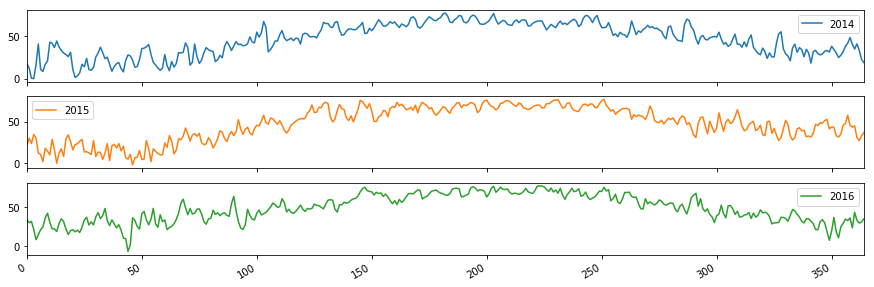

In [92]:
homeA_group_temp = pd.Series(homeA_group_temp['temperature'].values, index = pd.to_datetime(homeA_group_temp['Date']))
groups = homeA_group_temp.groupby(TimeGrouper(freq = 'A'))
years = pd.DataFrame()
for name, group in groups:
    years[name.year] = group.values
years.plot(subplots = True, legend = True)
plt.show()

##### Insights
The average temperature across all days in every year seems to have followed similar pattern.  


##### Energy consumption trend across 365 days in each year

In [ ]:
homeA_EDA['Date'] = homeA_EDA['Date & Time'].dt.date.apply(lambda x: x.strftime("%Y-%m-%d"))
homeA_EDA.sort_values('Date', inplace = True)
homeA_group_energy = homeA_EDA.groupby('Date', as_index = False)['total_usage [kW]'].sum()
homeA_group_energy.head()
homeA_group_energy = homeA_group_energy[homeA_group_energy.Date != '2016-02-29'] # remove the entry for 29th day (2016 - a leap year)

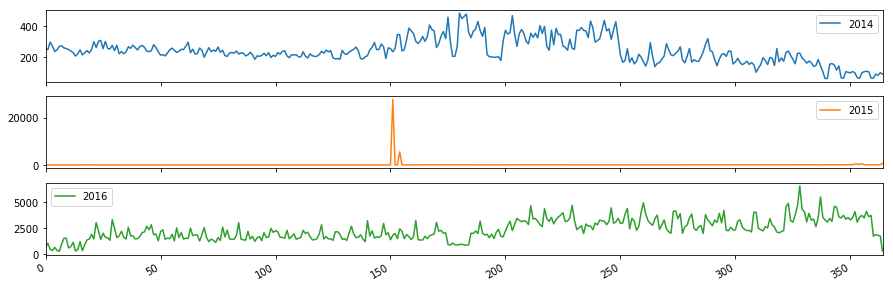

In [87]:
homeA_group_energy = pd.Series(homeA_group_energy['total_usage [kW]'].values, index = pd.to_datetime(homeA_group_energy['Date']))
groups = homeA_group_energy.groupby(TimeGrouper(freq = 'A'))
years = pd.DataFrame()
for name, group in groups:
    years[name.year] = group.values
years.plot(subplots = True, legend = True)
plt.show()

##### Insights
1. The energy consumption in 2015 was completely odd when compared to rest of the years
2. In 2014, the energy consumption for months from May to July was high where the temperature was also high
3. When compared the energy consumption of 2014 / 2016, both not following similar pattern

##### Average humidity trend across 365 days in each year

In [ ]:
homeA_EDA['Date'] = homeA_EDA['Date & Time'].dt.date.apply(lambda x: x.strftime("%Y-%m-%d"))
homeA_EDA.sort_values('Date', inplace = True)
homeA_group_humid = homeA_EDA.groupby('Date', as_index = False)['humidity'].mean()
homeA_group_humid = homeA_group_humid[homeA_group_humid.Date != '2016-02-29'] # remove the entry for 29th day (2016 - a leap year)

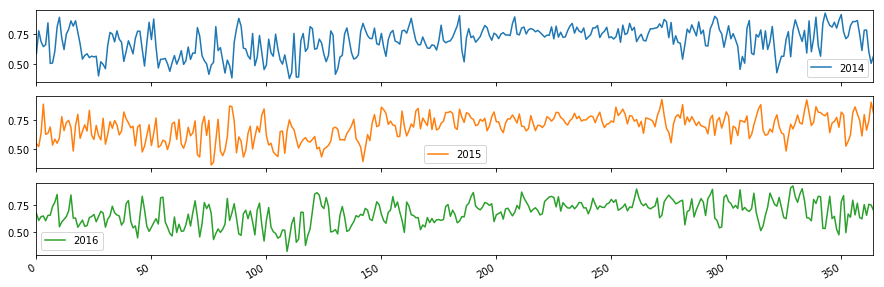

In [90]:
homeA_group_humid = pd.Series(homeA_group_humid['humidity'].values, index = pd.to_datetime(homeA_group_humid['Date']))
groups = homeA_group_humid.groupby(TimeGrouper(freq = 'A'))
years = pd.DataFrame()
for name, group in groups:
    years[name.year] = group.values
years.plot(subplots = True, legend = True)
plt.show()

##### Average visibility across 365 days in each year

In [93]:
homeA_EDA['Date'] = homeA_EDA['Date & Time'].dt.date.apply(lambda x: x.strftime("%Y-%m-%d"))
homeA_EDA.sort_values('Date', inplace = True)
homeA_group_visibility = homeA_EDA.groupby('Date', as_index = False)['visibility'].mean()
homeA_group_visibility = homeA_group_visibility[homeA_group_visibility.Date != '2016-02-29'] # remove the entry for 29th day (2016 - a leap year)

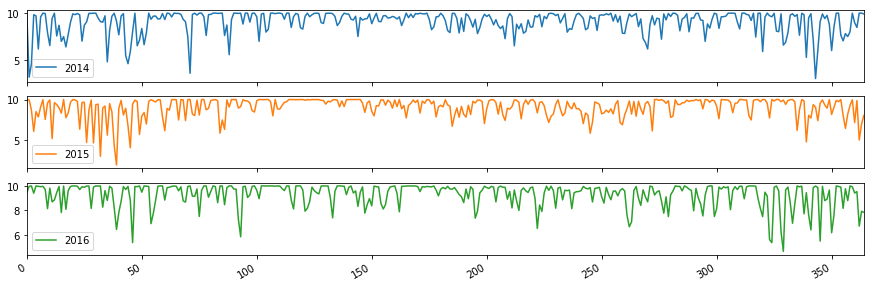

In [94]:
homeA_group_visibility = pd.Series(homeA_group_visibility['visibility'].values, index = pd.to_datetime(homeA_group_visibility['Date']))
groups = homeA_group_visibility.groupby(TimeGrouper(freq = 'A'))
years = pd.DataFrame()
for name, group in groups:
    years[name.year] = group.values
years.plot(subplots = True, legend = True)
plt.show()

### Time Series Box Plot and Whisker plots by Interval

This type of plot, useful to summarize the distribution of observations. This plot draws a box around the 
25th and 75th percentiles of the data that captures the middle 50% of observations. A line is drawn at 
the 50th percentile (the median) and whiskers are drawn above and below the box to summarize the general extents of the observations.
Dots are drawn for outliers outside the whiskers or extents of the data. Box and whisker plots can be created and compared 
for each interval in a time series, such as years, months, or days.

Below is obtained by grouping the average daily temprature by years, A box and whisker plot is then created for each year 
and lined up side-by-side for direct comparison.

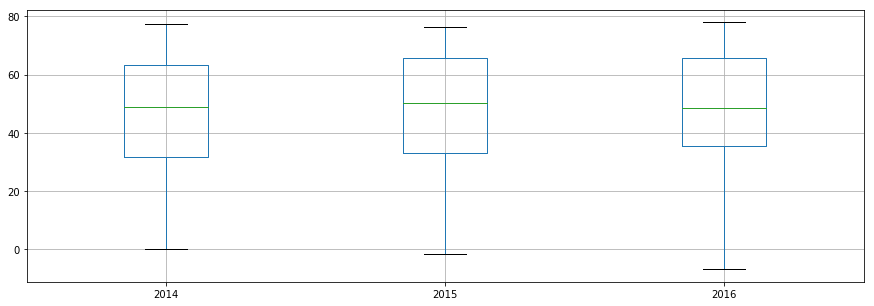

In [13]:
homeA_EDA['Date'] = homeA_EDA['Date & Time'].dt.date.apply(lambda x: x.strftime("%Y-%m-%d"))
homeA_EDA.sort_values('Date', inplace = True)
homeA_group_temp = homeA_EDA.groupby('Date', as_index = False)['temperature'].mean()
homeA_group_temp = homeA_group_temp[homeA_group_temp.Date != '2016-02-29'] # remove the entry for 29th day (2016 - a leap year)

homeA_group_temp = pd.Series(homeA_group_temp['temperature'].values, index = pd.to_datetime(homeA_group_temp['Date']))
groups = homeA_group_temp.groupby(TimeGrouper(freq = 'A'))
years = pd.DataFrame()
for name, group in groups:
    years[name.year] = group.values
years.boxplot(return_type = 'dict')
plt.show()

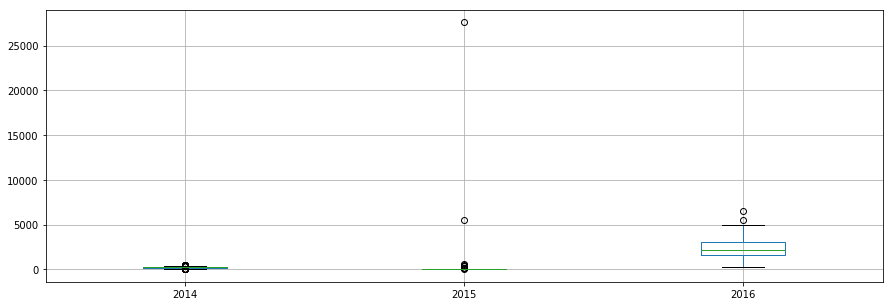

In [10]:
homeA_EDA['Da'] = homeA_EDA['Date & Time'].dt.date.apply(lambda x: x.strftime("%Y"))
homeA_EDA.sort_values('Date', inplace = True)
homeA_group_energy = homeA_EDA.groupby('Date', as_index = False)['total_usage [kW]'].sum()
homeA_group_energy.head()
homeA_group_energy = homeA_group_energy[homeA_group_energy.Date != '2016-02-29'] # remove the entry for 29th day (2016 - a leap year)

homeA_group_energy = pd.Series(homeA_group_energy['total_usage [kW]'].values, index = pd.to_datetime(homeA_group_energy['Date']))
groups = homeA_group_energy.groupby(TimeGrouper(freq = 'A'))
years = pd.DataFrame()
for name, group in groups:
    years[name.year] = group.values
years.boxplot(return_type = 'dict', )
plt.show()

We may also be interested in the distribution of values across months within a year.

The example below creates 12 box and whisker plots, one for each month of 2016, the last year in the dataset.

In the example, first, only observations from 2016 are extracted.

Then, the observations are grouped by month, and each month is added to a new DataFrame as a column.

Finally, a box and whisker plot is created for each month-column in the newly constructed DataFrame.

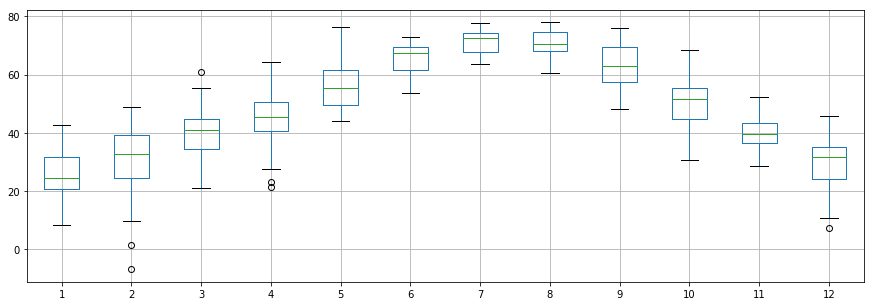

In [25]:
homeA_EDA = homeA_EDA[homeA_EDA.Year == 2016]
homeA_EDA['Date'] = homeA_EDA['Date & Time'].dt.date.apply(lambda x: x.strftime("%Y-%m-%d"))
homeA_EDA.sort_values('Date', inplace = True)
homeA_group_temp = homeA_EDA.groupby('Date', as_index = False)['temperature'].mean()
homeA_group_temp = pd.Series(homeA_group_temp['temperature'].values, index = pd.to_datetime(homeA_group_temp['Date']))
groups = homeA_group_temp.groupby(TimeGrouper(freq = 'M'))

months = concat([pd.DataFrame(x[1].values) for x in groups], axis = 1)
months.columns = range(1, 13)
months.boxplot(return_type = 'dict')
plt.show()

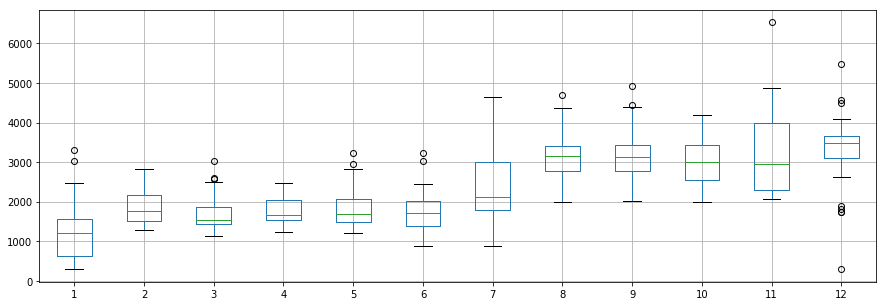

In [26]:
homeA_EDA = homeA_EDA[homeA_EDA.Year == 2016]
homeA_EDA['Date'] = homeA_EDA['Date & Time'].dt.date.apply(lambda x: x.strftime("%Y-%m-%d"))
homeA_EDA.sort_values('Date', inplace = True)
homeA_group_energy = homeA_EDA.groupby('Date', as_index = False)['total_usage [kW]'].sum()
homeA_group_energy = pd.Series(homeA_group_energy['total_usage [kW]'].values, index = pd.to_datetime(homeA_group_energy['Date']))
groups = homeA_group_energy.groupby(TimeGrouper(freq = 'M'))

months = concat([pd.DataFrame(x[1].values) for x in groups], axis = 1)
months.columns = range(1, 13)
months.boxplot(return_type = 'dict')
plt.show()

#### Insights

There is a significant change in energy use starting from the month of 5 to 12 where the temperature was also high.

#### Time Series Heatmaps

A matrix of numbers can be plotted as a surface, where the values in each cell of the matrix are assigned a unique color.

This is called a heatmap, as larger values can be drawn with warmer colors (yellows and reds)
and smaller values can be drawn with cooler colors (blues and greens).

Like the box and whisker plots, we can compare observations between intervals using a heat map.

In the case of the average Daily Temperatures, the observations can be arranged into a matrix of year-columns and day-rows, 
with average temperature in the cell for each day. A heat map of this matrix can then be plotted.

Below is an example of creating a heatmap of the average Daily Temperatures data. The matshow() function 
from the matplotlib library is used as no heatmap support is provided directly in Pandas.

For convenience, the matrix is rotation (transposed) so that each row represents one year and each column one day. 
This provides a more intuitive, left-to-right layout of the data.

In [38]:
rcParams['figure.figsize'] = 100, 50

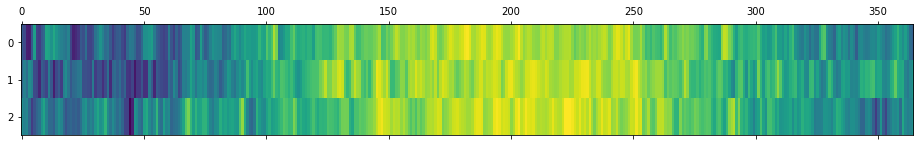

In [9]:
homeA_EDA['Date'] = homeA_EDA['Date & Time'].dt.date.apply(lambda x: x.strftime("%Y-%m-%d"))
homeA_EDA.sort_values('Date', inplace = True)
homeA_group_temp = homeA_EDA.groupby('Date', as_index = False)['temperature'].mean()
homeA_group_temp = homeA_group_temp[homeA_group_temp.Date != '2016-02-29'] # remove the entry for 29th day (2016 - a leap year)

homeA_group_temp = pd.Series(homeA_group_temp['temperature'].values, index = pd.to_datetime(homeA_group_temp['Date']))
groups = homeA_group_temp.groupby(TimeGrouper(freq = 'A'))
years = pd.DataFrame()
for name, group in groups:
    years[name.year] = group.values

years = years.T
plt.matshow(years, interpolation = None, aspect = 'auto')
plt.show()

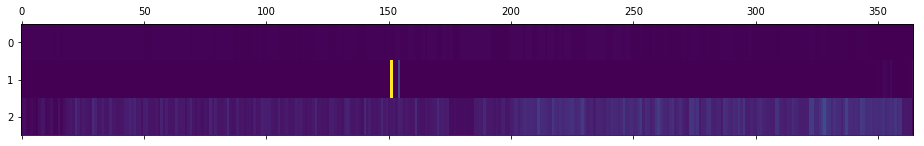

In [54]:
homeA_EDA['Date'] = homeA_EDA['Date & Time'].dt.date.apply(lambda x: x.strftime("%Y-%m-%d"))
homeA_EDA.sort_values('Date', inplace = True)
homeA_group_energy = homeA_EDA.groupby('Date', as_index = False)['total_usage [kW]'].sum()
homeA_group_energy = homeA_group_energy[homeA_group_energy.Date != '2016-02-29'] # remove the entry for 29th day (2016 - a leap year)
homeA_group_energy = pd.Series(homeA_group_energy['total_usage [kW]'].values, index = pd.to_datetime(homeA_group_energy['Date']))
groups = homeA_group_energy.groupby(TimeGrouper(freq = 'A'))
years = pd.DataFrame()
for name, group in groups:
    years[name.year] = group.values
years = years.T
plt.matshow(years, interpolation = None, aspect = 'auto')
plt.show()

We can also compare the months within a year. 
Below is an example of a heat map comparing the months of the year in 2016. Each column represents one month, 
with rows representing the days of the month from 1 to 31.

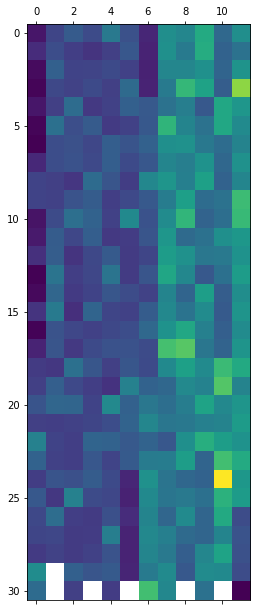

In [57]:
homeA_EDA = homeA_EDA[homeA_EDA.Year == 2016]
homeA_EDA['Date'] = homeA_EDA['Date & Time'].dt.date.apply(lambda x: x.strftime("%Y-%m-%d"))
homeA_EDA.sort_values('Date', inplace = True)
homeA_group_energy = homeA_EDA.groupby('Date', as_index = False)['total_usage [kW]'].sum()
homeA_group_energy = pd.Series(homeA_group_energy['total_usage [kW]'].values, index = pd.to_datetime(homeA_group_energy['Date']))
groups = homeA_group_energy.groupby(TimeGrouper(freq = 'M'))

months = concat([pd.DataFrame(x[1].values) for x in groups], axis = 1)
months.columns = range(1, 13)
plt.matshow(months, interpolation = None, aspect = 'auto')
plt.show()

First 6 months in 2016, the energy use is at lower level and 24th day in 10 month, the yellow color shows the higher consumption.
The white patches are missing values represents the months that have fewer than 31 days. 

##### Time Series Lag Scatter plots
Time series modeling assumes a relationship between an observation and the previous observation.

Previous observations in a time series are called lags, with the observation at the previous time step called lag1, 
the observation at two time steps ago lag2, and so on.

A useful type of plot to explore the relationship between each observation and a lag of that observation is called the scatter plot.

Pandas has a built-in function for exactly this called the lag plot. It plots the observation at time t on the x-axis 
and the lag1 observation (t-1) on the y-axis.

1. If the points cluster along a diagonal line from the bottom-left to the top-right of the plot, it suggests a positive correlation relationship.
2. If the points cluster along a diagonal line from the top-left to the bottom-right, it suggests a negative correlation relationship.
3. Either relationship is good as they can be modeled.
   More points tighter in to the diagonal line suggests a stronger relationship and more spread from the line suggests a weaker relationship.

A ball in the middle or a spread across the plot suggests a weak or no relationship.

Below are the examples of a lag plot for the average Daily Temperatures dataset and total energy use.

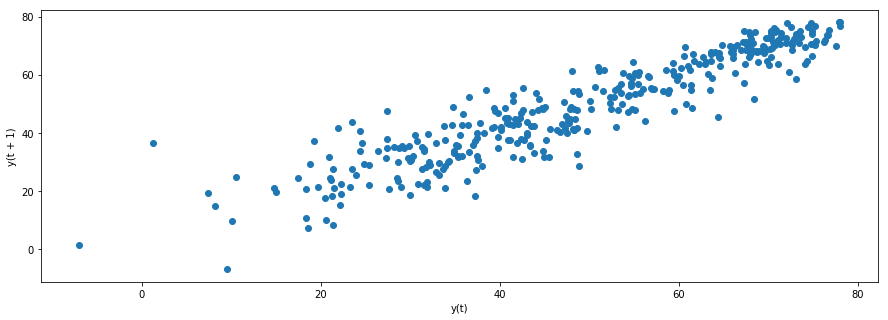

In [59]:
homeA_EDA['Date'] = homeA_EDA['Date & Time'].dt.date.apply(lambda x: x.strftime("%Y-%m-%d"))
homeA_EDA.sort_values('Date', inplace = True)
homeA_group_temp = homeA_EDA.groupby('Date', as_index = False)['temperature'].mean()
homeA_group_temp = pd.Series(homeA_group_temp['temperature'].values, index = pd.to_datetime(homeA_group_temp['Date']))
lag_plot(homeA_group_temp)
plt.show()

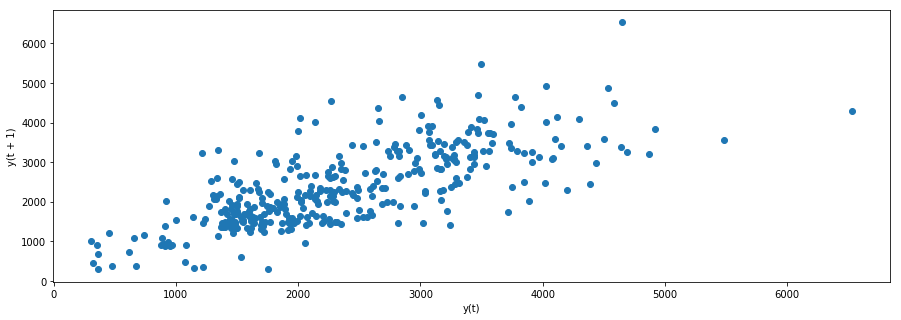

In [60]:
homeA_EDA['Date'] = homeA_EDA['Date & Time'].dt.date.apply(lambda x: x.strftime("%Y-%m-%d"))
homeA_EDA.sort_values('Date', inplace = True)
homeA_group_energy = homeA_EDA.groupby('Date', as_index = False)['total_usage [kW]'].sum()
homeA_group_energy = pd.Series(homeA_group_energy['total_usage [kW]'].values, index = pd.to_datetime(homeA_group_energy['Date']))
lag_plot(homeA_group_energy)
plt.show()

In [62]:
homeA_EDA = homeA_EDA[homeA_EDA.Year == 2016]
homeA_EDA['Date'] = homeA_EDA['Date & Time'].dt.date.apply(lambda x: x.strftime("%Y-%m-%d"))
homeA_EDA.sort_values('Date', inplace = True)
homeA_group_energy = homeA_EDA.groupby('Date', as_index = False)['total_usage [kW]'].sum()
homeA_group_energy = pd.Series(homeA_group_energy['total_usage [kW]'].values, index = pd.to_datetime(homeA_group_energy['Date']))

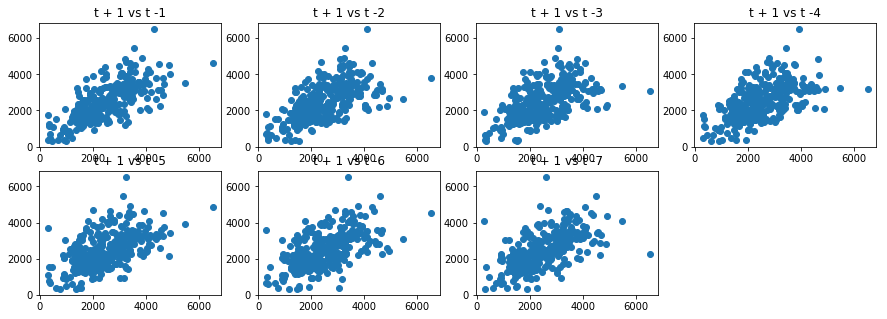

In [74]:
values = pd.DataFrame(homeA_group_energy.values)
lags = 7
columns = [values]
for i in range(1, (lags + 1)):
    columns.append(values.shift(i))
dataframe = concat(columns, axis = 1)

columns = ['t+1']
for i in range(1, (lags + 1)):
    columns.append('t-'+ str(i))
dataframe.columns = columns

plt.figure(1)
for i in range(1, (lags + 1)):
    ax = plt.subplot(240 + i)
    ax.set_title('t + 1 vs t -' + str(i))
    plt.scatter(x = dataframe['t+1'].values, y = dataframe['t-'+str(i)].values)
plt.show()

##### Time Series Auto Correlation Plots

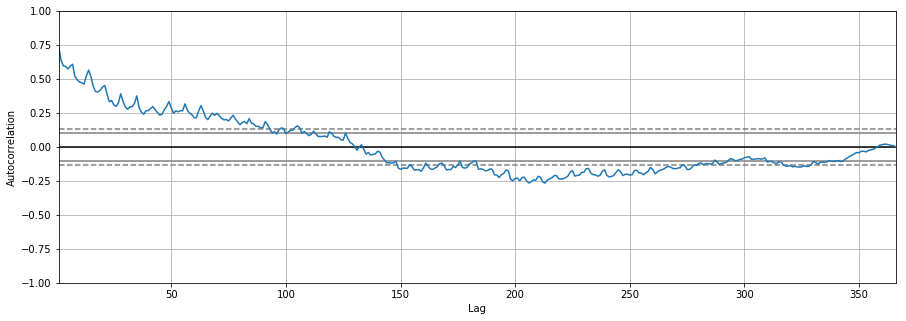

In [79]:
homeA_EDA = homeA_EDA[homeA_EDA.Year == 2016]
homeA_EDA['Date'] = homeA_EDA['Date & Time'].dt.date.apply(lambda x: x.strftime("%Y-%m-%d"))
homeA_EDA.sort_values('Date', inplace = True)
homeA_group_energy = homeA_EDA.groupby('Date', as_index = False)['total_usage [kW]'].sum()
homeA_group_energy = pd.Series(homeA_group_energy['total_usage [kW]'].values, index = pd.to_datetime(homeA_group_energy['Date']))
autocorrelation_plot(homeA_group_energy)
plt.show()

In [ ]:
g = sns.PairGrid(homeA_EDA_sample, vars = ['windSpeed', 'total_usage [kW]'])
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
plt.add_legend()
plt.show()

# Home B

In [ ]:
df_homeB = pd.read_csv("/home/dp_gcp/dsiot/HomeB/consol/df_final_HomeB.csv", sep = ",", index_col = None, parse_dates = [3])
df_homeB = df_homeB.fillna(0.0)

In [ ]:
df_homeB['Date'] = df_homeB['Date & Time'].dt.date.apply(lambda x: x.strftime("%Y-%m-%d"))
df_homeB['Time'] = df_homeB['Date & Time'].dt.time
df_homeB['Year'] = df_homeB['Date'].str.slice(0, 4)
df_homeB['Month'] = df_homeB['Date'].str.slice(5, 7)
df_homeB['Dt'] = df_homeB['Date'].str.slice(8, 10)

In [ ]:
cols = [col for col in df_homeB.columns if col not in ['Date & Time', 'old usage [kW]', 'use [kW]', 'gen [kW]', 'home-index', 'Date', 'Time', 'Year','Month', 'Dt']]

In [ ]:
df_homeB_sum_date = df_homeB.groupby(['Year', 'Month'], as_index = False)[cols].sum()
df_homeB_totaluse_date= df_homeB_sum_date[cols].apply(lambda row: np.sum(row), axis = 1)

In [ ]:
df_homeB_totaluse_date = df_homeB_totaluse_date.to_frame(name = 'total_usage')
df_homeB_agg = pd.merge(df_homeB_sum_date[['Year', 'Month']], df_homeB_totaluse_date, left_index = True, right_index = True)
df_homeB_agg['home_index'] = 'Home B'
df_homeB_agg.to_csv(os.getcwd()+'/HomeB/df_homeB_agg.csv', index = False)

#### Merging total usage with weather related info file (starts from here)

In [ ]:
df__homeB = pd.read_csv("/home/dp_gcp/dsiot/HomeB/df__HomeB.csv", sep = ",", index_col = None, parse_dates = ['Date & Time'])

In [ ]:
df_homeB_totaluse_date= df_homeB[cols].apply(lambda row: np.sum(row), axis = 1)
df_homeB_totaluse_date = df_homeB_totaluse_date.to_frame(name = 'total_usage')
df_homeB = pd.merge(df_homeB, df_homeB_totaluse_date, left_index = True, right_index = True)

df_homeB_agg = pd.merge(df__homeB, df_homeB[['total_usage', 'gen [kW]', 'use [kW]']], left_index = ['Date & Time'], right_index = ['Date & Time'])
df_homeB_agg.to_csv('/home/dp_gcp/dsiot/HomeB/df__HomeB_agg.csv', index = False)

# Home C

In [ ]:
df_homeC = pd.read_csv("/home/dp_gcp/dsiot/HomeC/consol/df_final_HomeC.csv", sep = ",", index_col = None, parse_dates = [1])
df_homeC = df_homeC.fillna(0.0)

In [ ]:
df_homeC['Date'] = df_homeC['Date & Time'].dt.date.apply(lambda x: x.strftime("%Y-%m-%d"))
df_homeC['Time'] = df_homeC['Date & Time'].dt.time
df_homeC['Year'] = df_homeC['Date'].str.slice(0, 4)
df_homeC['Month'] = df_homeC['Date'].str.slice(5, 7)
df_homeC['Dt'] = df_homeC['Date'].str.slice(8, 10)

In [ ]:
print (df_homeC.columns)

In [ ]:
cols = [col for col in df_homeC.columns if col not in ['Date & Time', 'use [kW]', 'gen [kW]', 'home-index', 'Date', 'Time', 'Year','Month', 'Dt']]

In [ ]:
df_homeC_sum_date = df_homeC.groupby('Date', as_index = False)[cols].sum()
df_homeC_totaluse_date= df_homeC_sum_date[cols].apply(lambda row: np.sum(row), axis = 1)

In [ ]:
df_homeC_totaluse_date = df_homeC_totaluse_date.to_frame(name = 'total_usage')
df_homeC_agg = pd.merge(df_homeC_sum_date[['Date']], df_homeC_totaluse_date, left_index = True, right_index = True)
df_homeC_agg['home_index'] = 'Home C'
df_homeC_agg.to_csv(os.getcwd()+'/HomeC/df_homeC_agg.csv', index = False)

#### Merging total usage with weather related info file (starts from here)

In [ ]:
df__homeC = pd.read_csv("/home/dp_gcp/dsiot/HomeC/df__HomeC.csv", sep = ",", index_col = None, parse_dates = ['Date & Time'])

In [ ]:
df_homeC_totaluse_date= df_homeC[cols].apply(lambda row: np.sum(row), axis = 1)
df_homeC_totaluse_date = df_homeC_totaluse_date.to_frame(name = 'total_usage')
df_homeC = pd.merge(df_homeC, df_homeC_totaluse_date, left_index = True, right_index = True)

df_homeC_agg = pd.merge(df__homeC, df_homeC[['total_usage', 'gen [kW]', 'use [kW]']], left_index = ['Date & Time'], right_index = ['Date & Time'])
df_homeC_agg.to_csv('/home/dp_gcp/dsiot/HomeC/df__HomeC_agg.csv', index = False)

# Home D

In [ ]:
df_homeD = pd.read_csv("/home/dp_gcp/dsiot/HomeD/consol/df_final_HomeD.csv", sep = ",", index_col = None, parse_dates = [2])
df_homeD = df_homeD.fillna(0.0)

In [ ]:
df_homeD['Date'] = df_homeD['Date & Time'].dt.date.apply(lambda x: x.strftime("%Y-%m-%d"))
df_homeD['Time'] = df_homeD['Date & Time'].dt.time
df_homeD['Year'] = df_homeD['Date'].str.slice(0, 4)
df_homeD['Month'] = df_homeD['Date'].str.slice(5, 7)
df_homeD['Dt'] = df_homeD['Date'].str.slice(8, 10)

In [ ]:
cols = [col for col in df_homeD.columns if col not in ['Date & Time', 'use [kW]', 'gen [kW]', 'home-index', 'Date', 'Time', 'Year','Month', 'Dt']]

In [ ]:
df_homeD_sum_date = df_homeD.groupby('Date', as_index = False)[cols].sum()
df_homeD_totaluse_date= df_homeD_sum_date[cols].apply(lambda row: np.sum(row), axis = 1)

In [ ]:
df_homeD_totaluse_date = df_homeD_totaluse_date.to_frame(name = 'total_usage')
df_homeD_agg = pd.merge(df_homeD_sum_date[['Date']], df_homeD_totaluse_date, left_index = True, right_index = True)
df_homeD_agg['home_index'] = 'Home D'
df_homeD_agg.to_csv(os.getcwd()+'/HomeD/df_homeD_agg.csv', index = False)

#### Merging total usage with weather related info file (starts from here)

In [ ]:
df__homeD = pd.read_csv("/home/dp_gcp/dsiot/HomeD/df__HomeD.csv", sep = ",", index_col = None, parse_dates = ['Date & Time'])

In [ ]:
df_homeD_totaluse_date= df_homeD[cols].apply(lambda row: np.sum(row), axis = 1)
df_homeD_totaluse_date = df_homeD_totaluse_date.to_frame(name = 'total_usage')
df_homeD = pd.merge(df_homeD, df_homeD_totaluse_date, left_index = True, right_index = True)

df_homeD_adf__homeD = pd.read_csv("/home/dp_gcp/dsiot/HomeD/df__HomeD.csv", sep = ",", index_col = None, parse_dates = ['Date & Time'])df__homeD = pd.read_csv("/home/dp_gcp/dsiot/HomeD/df__HomeD.csv", sep = ",", index_col = None, parse_dates = ['Date & Time'])gg = pd.merge(df__homeD, df_homeD[['total_usage', 'gen [kW]', 'use [kW]']], left_index = ['Date & Time'], right_index = ['Date & Time'])
df_homeD_agg.to_csv('/home/dp_gcp/dsiot/HomeD/df__homeD_agg.csv', index = False)

# Home F

In [ ]:
df_homeF = pd.read_csv("/home/dp_gcp/dsiot/HomeF/consol/df_final_HomeF.csv", sep = ",", index_col = None, parse_dates = ['Date & Time'])
df_homeF = df_homeF.fillna(0.0)

In [ ]:
df_homeF['Date'] = df_homeF['Date & Time'].dt.date.apply(lambda x: x.strftime("%Y-%m-%d"))
df_homeF['Time'] = df_homeF['Date & Time'].dt.time
df_homeF['Year'] = df_homeF['Date'].str.slice(0, 4)
df_homeF['Month'] = df_homeF['Date'].str.slice(5, 7)
df_homeF['Dt'] = df_homeF['Date'].str.slice(8, 10)

In [ ]:
cols = [col for col in df_homeF.columns if col not in ['Date & Time', 'Usage [kW]', 'Generation [kW]', 'home-index', 'Date', 'Time', 'Year','Month', 'Dt']]

In [ ]:
df_homeF_sum_date = df_homeF.groupby('Date', as_index = False)[cols].sum()
df_homeF_totaluse_date= df_homeF_sum_date[cols].apply(lambda row: np.sum(row), axis = 1)

In [ ]:
df_homeF_totaluse_date = df_homeF_totaluse_date.to_frame(name = 'total_usage')
df_homeF_agg = pd.merge(df_homeF_sum_date[['Date']], df_homeF_totaluse_date, left_index = True, right_index = True)
df_homeF_agg['home_index'] = 'Home F'
df_homeF_agg.to_csv(os.getcwd()+'/HomeF/df_homeF_agg.csv', index = False)

#### Merging total usage with weather related info file (starts from here)

In [ ]:
df__homeF = pd.read_csv("/home/dp_gcp/dsiot/HomeF/df__HomeF.csv", sep = ",", index_col = None, parse_dates = ['Date & Time'])

In [ ]:
df_homeF_totaluse_date= df_homeF[cols].apply(lambda row: np.sum(row), axis = 1)
df_homeF_totaluse_date = df_homeF_totaluse_date.to_frame(name = 'total_usage')
df_homeF = pd.merge(df_homeF, df_homeF_totaluse_date, left_index = True, right_index = True)

df_homeF_agg = pd.merge(df__homeF, df_homeF[['total_usage', 'Generation [kW]', 'Usage [kW]']], left_index = ['Date & Time'], right_index = ['Date & Time'])
df_homeF_agg.to_csv('/home/dp_gcp/dsiot/HomeF/df__homeF_agg.csv', index = False)

# Home G

In [ ]:
df_homeG = pd.read_csv("/home/dp_gcp/dsiot/HomeG/consol/df_final_HomeG.csv", sep = ",", index_col = None, parse_dates = ['Date & Time'])
df_homeG = df_homeG.fillna(0.0)

In [ ]:
df_homeG['Date'] = df_homeG['Date & Time'].dt.date.apply(lambda x: x.strftime("%Y-%m-%d"))
df_homeG['Time'] = df_homeG['Date & Time'].dt.time
df_homeG['Year'] = df_homeG['Date'].str.slice(0, 4)
df_homeG['Month'] = df_homeG['Date'].str.slice(5, 7)
df_homeG['Dt'] = df_homeG['Date'].str.slice(8, 10)

In [ ]:
cols = [col for col in df_homeG.columns if col not in ['Date & Time', 'use [kW]', 'gen [kW]', 'home-index', 'Date', 'Time', 'Year','Month', 'Dt']]

In [ ]:
df_homeG_sum_date = df_homeG.groupby('Date', as_index = False)[cols].sum()
df_homeG_totaluse_date= df_homeG_sum_date[cols].apply(lambda row: np.sum(row), axis = 1)

In [ ]:
df_homeG_totaluse_date = df_homeG_totaluse_date.to_frame(name = 'total_usage')
df_homeG_agg = pd.merge(df_homeG_sum_date[['Date']], df_homeG_totaluse_date, left_index = True, right_index = True)
df_homeG_agg['home_index'] = 'Home G'
df_homeG_agg.to_csv(os.getcwd()+'/HomeG/df_homeG_agg.csv', index = False)

#### Merging total usage with weather related info file (starts from here)

In [ ]:
df__homeG = pd.read_csv("/home/dp_gcp/dsiot/HomeG/df__HomeG.csv", sep = ",", index_col = None, parse_dates = ['Date & Time'])

In [ ]:
df_homeG_totaluse_date= df_homeG[cols].apply(lambda row: np.sum(row), axis = 1)
df_homeG_totaluse_date = df_homeG_totaluse_date.to_frame(name = 'total_usage')
df_homeG = pd.merge(df_homeG, df_homeG_totaluse_date, left_index = True, right_index = True)

df_homeG_agg = pd.merge(df__homeG, df_homeG[['total_usage', 'gen [kW]', 'use [kW]']], left_index = ['Date & Time'], right_index = ['Date & Time'])
df_homeG_agg.to_csv('/home/dp_gcp/dsiot/HomeG/df__homeG_agg.csv', index = False)

# Home H

In [ ]:
df_homeH = pd.read_csv("/home/dp_gcp/dsiot/HomeH/consol/df_final_HomeH.csv", sep = ",", index_col = None, parse_dates = ['Date & Time'])
df_homeH = df_homeH.fillna(0.0)

In [ ]:
df_homeH['Date'] = df_homeH['Date & Time'].dt.date.apply(lambda x: x.strftime("%Y-%m-%d"))
df_homeH['Time'] = df_homeH['Date & Time'].dt.time
df_homeH['Year'] = df_homeH['Date'].str.slice(0, 4)
df_homeH['Month'] = df_homeH['Date'].str.slice(5, 7)
df_homeH['Dt'] = df_homeH['Date'].str.slice(8, 10)

In [ ]:
cols = [col for col in df_homeH.columns if col not in ['Date & Time', 'Usage [kW]', 'Generation [kW]', 'home-index', 'Date', 'Time', 'Year','Month', 'Dt']]

In [ ]:
df_homeH_sum_date = df_homeH.groupby('Date', as_index = False)[cols].sum()
df_homeH_totaluse_date= df_homeH_sum_date[cols].apply(lambda row: np.sum(row), axis = 1)

In [ ]:
df_homeH_totaluse_date = df_homeH_totaluse_date.to_frame(name = 'total_usage')
df_homeH_agg = pd.merge(df_homeH_sum_date[['Date']], df_homeH_totaluse_date, left_index = True, right_index = True)
df_homeH_agg['home_index'] = 'Home H'
df_homeH_agg.to_csv(os.getcwd()+'/HomeH/df_homeH_agg.csv', index = False)

#### Merging total usage with weather related info file (starts from here)

In [ ]:
df__homeH = pd.read_csv("/home/dp_gcp/dsiot/HomeH/df__HomeH.csv", sep = ",", index_col = None, parse_dates = ['Date & Time'])

In [ ]:
df_homeH_totaluse_date= df_homeH[cols].apply(lambda row: np.sum(row), axis = 1)
df_homeH_totaluse_date = df_homeH_totaluse_date.to_frame(name = 'total_usage')
df_homeH = pd.merge(df_homeH, df_homeH_totaluse_date, left_index = True, right_index = True)

df_homeG_agg = pd.merge(df__homeH, df_homeH[['total_usage', 'Generation [kW]', 'Usage [kW]']], left_index = ['Date & Time'], right_index = ['Date & Time'])
df_homeG_agg.to_csv('/home/dp_gcp/dsiot/HomeH/df__homeH_agg.csv', index = False)